In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from collections import Counter
from sklearn.linear_model import LinearRegression
import numba
from scipy.stats import pearsonr
from tqdm import tqdm
from skimage.io import imread

In [3]:
def load_basic_params():
    fov_list = [201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229]
    r = 10
    c = 2

    return fov_list, r, c

def load_barcodes(r,c):
    # only add background to the df
    df_barcodes = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/barcodes.csv', index_col=0)
    df_barcodes.drop('id', axis=1, inplace=True)
    df_barcodes.index.name = 'code_name'
    df_barcodes = df_barcodes.reset_index()
    df_barcodes.index += 1
    df_barcodes.loc[266] = ['Background'] + [0]*20
    df_barcodes.loc[267] = ['Unknown'] + [-1]*20
    barcodes_idx2name = dict(zip(1+np.arange(len(df_barcodes)), df_barcodes.code_name.values))
    ch_names = list(df_barcodes.columns)
    ch_names.remove('code_name')
    barcodes_array = df_barcodes[ch_names].values.reshape(-1,r,c)[:-2, :,:] # only the valid & blank genes
    return df_barcodes, ch_names, barcodes_idx2name, barcodes_array

def get_counts(all_dfs, all_names, df_barcodes):
    M = len(all_dfs)
    df_count = pd.concat([pd.DataFrame.from_dict(Counter(all_dfs[idx].predicted_id), orient='index', columns=[all_names[idx]]) for idx in range(M)], axis=1)
    df_count = df_count.sort_index()
    df_count = df_count.fillna(0).astype(np.int)
    df_ratio  = df_count/df_count.sum()*100

    df_count['code_name'] = df_barcodes.code_name
    df_ratio['code_name'] = df_barcodes.code_name
    
    return df_count, df_ratio

def calculate_other_genes(df_count, df_ratio):
    blank_indices = ['Blank' in item for item in df_count.code_name]

    def _cal_df_other(df):
        df_other = pd.concat([
            df.loc[df.code_name == 'Background'].set_index('code_name'),  # Background
            df.loc[df.code_name == 'Unknown'].set_index('code_name'),  # Unknown
            pd.DataFrame(df.loc[blank_indices, all_names].sum(axis=0), columns=['Blank']).T # Blank
        ])
        return df_other
    
    df_count_other = _cal_df_other(df_count)
    df_ratio_other = _cal_df_other(df_ratio)
    return df_count_other, df_ratio_other

def add_FPKM_into_dfs(df_count, df_ratio, df_bulkseq):
    df_count_aug = pd.concat([df_count, df_bulkseq[['FPKM']]], axis=1)
    df_count_aug = df_count_aug.fillna(0)
    
    df_bulkseq_ratio = df_bulkseq[['FPKM']] / df_bulkseq[['FPKM']].sum()
    df_ratio_aug = pd.concat([df_ratio, df_bulkseq_ratio], axis=1) 
    df_ratio_aug = df_ratio_aug.fillna(0)

    # drop_Mptx2
    df_count_aug = df_count_aug.drop([8])    
    df_ratio_aug = df_ratio_aug.drop([8])
        
    return df_count_aug, df_ratio_aug


In [5]:
# Load data
fov_list, r, c = load_basic_params()
df_barcodes, ch_names, barcodes_idx2name, barcodes_array = load_barcodes(r,c)

data_path_dict = {
'Moffitt': '/data/Spots_barcode_Emily/dataset_2/decoded_spots_moffitt.csv',
'Trackpy+PoSTcode': '/data/Spots_barcode_Emily/dataset_2/output_expr_comparison/original_postcode_old/decoded_spots_all_fovs_trunc.csv',
'Polaris+Rel. Bern.': '/data/Spots_barcode_Emily/dataset_2/output_expr_comparison/relaxed_bernoulli_2*R*C/decoded_spots_all_fovs_clip99.9_thres0.85_trunc.csv',
'Polaris+PoSTcode': '/data/Spots_barcode_Emily/dataset_5/output_expr_comparison/original_postcode_old/decoded_spots_all_fovs_trunc.csv',
    }

all_names = []
all_dfs = []
for name, path in data_path_dict.items():
    all_names.append(name)
    all_dfs.append(pd.read_csv(path, index_col=0))

df_bulkseq = pd.read_csv('/data/moffit_lab/bulk_FPKM.csv')
df_bulkseq.index += 1
df_bulkseq.rename(columns={'geneName': 'code_name'}, inplace=True)

In [6]:
# Calculate counts and ratios
df_count, df_ratio = get_counts(all_dfs, all_names, df_barcodes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## fig s7a

In [ ]:
df_count_per_cell_aug = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/output_expr_comparison/df_count_per_cell_aug.csv', index_col=0)

df_subset = df_count_per_cell_aug.iloc[:-2] # remove Background and Unknown
df_subset = df_subset[df_subset['FPKM'] != 0] # remove 0-count FPKM genes

total_cell_count = 0
for fov_id in fov_list:
    total_cell_count += mask_dict[fov_id].max()
eps = 1/total_cell_count
df_subset = df_subset.replace(0, eps) # replace 0 with eps

In [117]:
expr_list = ['Polaris+Rel. Bern.', 'Moffitt', 'Trackpy+PoSTcode']
label_list = ['Polaris', 'Petukhov, et al.', 'PoSTcode']
dot_color_list = ['grey', 'yellowgreen', 'coral']
line_color_list = ['k', 'green', 'r']

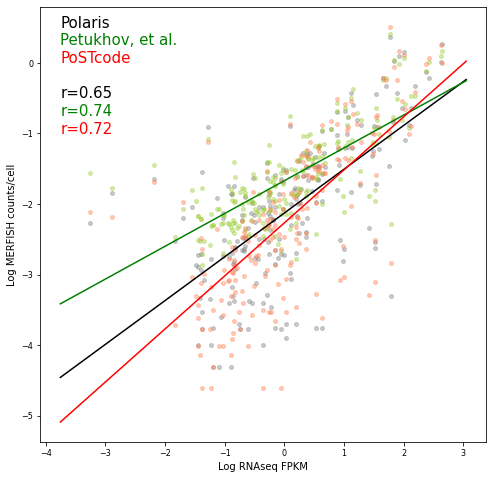

In [126]:
plt.figure(figsize=(8,8))

x = np.log10(df_subset['FPKM'].values)

for idx, name in enumerate(expr_list):
    y = np.log10(df_subset[name].values)
    reg = LinearRegression(fit_intercept=True).fit(x.reshape(-1, 1), y.reshape(-1, 1))
    plt.scatter(x, y,c=dot_color_list[idx], s=15, alpha=0.4)
        
    xx = np.arange(x.min() - 0.5, x.max() + 0.5, 0.1).reshape(-1, 1)
    yy = reg.predict(xx)
    plt.plot(xx, yy, c=line_color_list[idx])
    
    plt.annotate(label_list[idx], (-3.75,-0.25*idx+0.5), fontsize=15, color=line_color_list[idx])
    
    plt.annotate('r=%.2f'%(pearsonr(x,y)[0]), (-3.75,-0.25*idx-0.5), fontsize=15, color=line_color_list[idx])

plt.xlabel('Log RNAseq FPKM')
plt.ylabel('Log MERFISH counts/cell')
# plt.xlim([-4,4])
# plt.ylim([-4,1.6])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal'}

matplotlib.rc('font', **font)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## fig s7b

In [153]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


# TODO: why re-write pearsonr?
@numba.jit(nopython=True)
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient.
    """
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.std(x) / np.std(y) \
                / np.sqrt(len(x)) / np.sqrt(len(y))

@numba.jit(nopython=True)
def draw_bs_pairs_reps_pearson(x, y, size=1):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        
        out[i] = pearson_r(*draw_bs_pairs(x, y))
    return out

In [160]:
bs_reps_list = []

x = np.log10(df_subset['FPKM'].values)
for idx, name in enumerate(expr_list):
    y = np.log10(df_subset[name].values)
    bs_reps = draw_bs_pairs_reps_pearson(x, 
                                         y,
                                         size=10000)
    bs_reps_list.append(bs_reps)

Text(0, 0.5, 'Pearson corr. (r)')

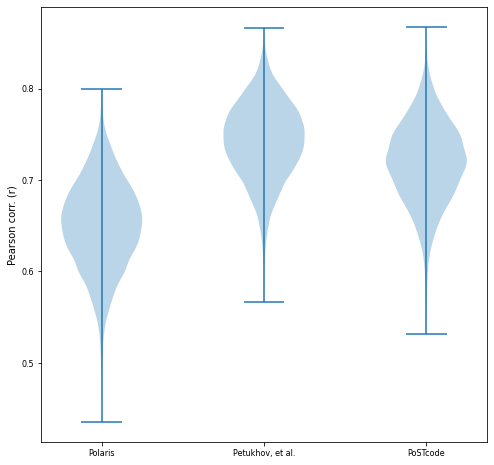

In [161]:
plt.figure(figsize=(8,8))
plt.violinplot(bs_reps_list)
plt.xticks([1,2,3], ['Polaris', 'Petukhov, et al.', 'PoSTcode'])
plt.ylabel('Pearson corr. (r)')

## fig s7c

In [165]:
df_count_other, df_ratio_other = calculate_other_genes(df_count, df_ratio)

In [182]:
df_ratio_other1 = df_ratio_other / 100

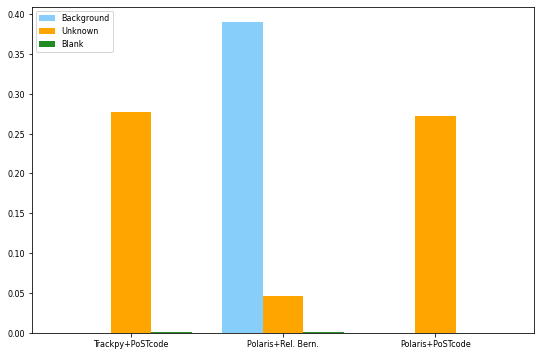

In [183]:
# Linear
df_ratio_other1[all_names[1:]].T.plot.bar(color=['lightskyblue', 'orange', 'forestgreen'], width=0.8, rot=0, figsize=(9,6)).legend(loc='upper left')

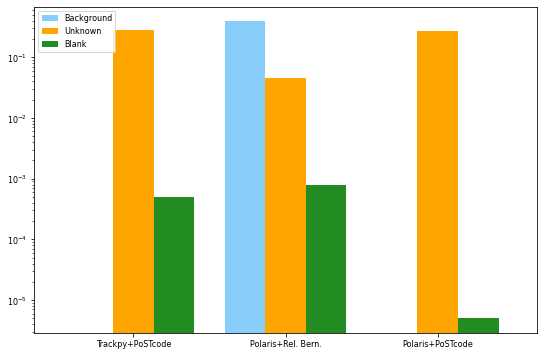

In [184]:
# Log
df_ratio_other1[all_names[1:]].T\
                    .plot.bar(color=['lightskyblue', 'orange', 'forestgreen'], width=0.8, rot=0, figsize=(9,6), logy=True).legend(loc='upper left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


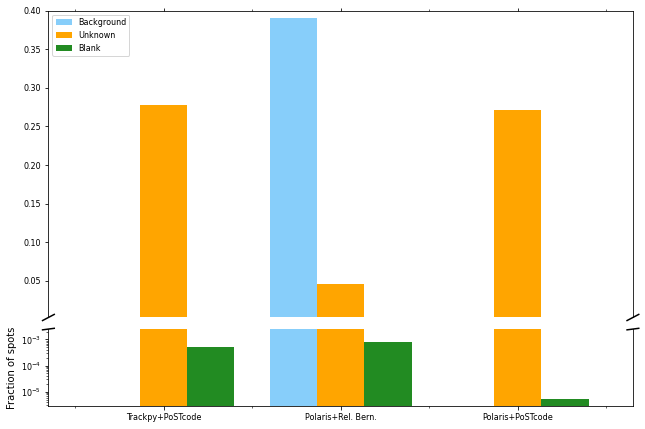

In [187]:
# Split

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})

df_ratio_other1[all_names[1:]].T\
                    .plot.bar(color=['lightskyblue', 'orange', 'forestgreen'], width=0.8, rot=0, figsize=(9,6), logy=False, ax=ax).legend(loc='upper left')

df_ratio_other1[all_names[1:]].T\
                    .plot.bar(color=['lightskyblue', 'orange', 'forestgreen'], width=0.8, rot=0, figsize=(9,6), logy=True, ax=ax2, legend=False)

ax.set_ylim(0.0025, 0.4)  # outliers only
ax2.set_ylim(0, 0.0025) 
ax2.set_yscale('log')

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Fraction of spots')
plt.tight_layout()